# Домашнее задание. Классификация изображений

**Мой kaggle: Vasiliy Kuzmin**

**Team name: Василий_Кузьмин_505358689**

В этом ноутбуке я убрал установление некоторых зависиомстей, потому что без них все вполне себе работает


### Установка зависимостей

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!unzip -q /content/gdrive/MyDrive/journey-springfield.zip -d train
!unzip -q /content/gdrive/MyDrive/journey-springfield.zip -d test

In [ ]:
!ls train/

characters_illustration.png  sample_submission.csv  testset  train


In [ ]:
!nvidia-smi
import torch
torch.cuda.is_available()

Tue Apr 18 06:13:12 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

In [ ]:
import pickle
import numpy as np
from skimage import io
from collections import Counter

from tqdm.notebook import tqdm
import time
from PIL import Image
from pathlib import Path

import torch
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import WeightedRandomSampler
from torchvision import datasets, models, transforms
import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.metrics import f1_score

import seaborn as sns

from matplotlib import colors, pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [ ]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

Изменим немного класс SimpsonsDataset. Добавим в него аугментацию и уберем ненужные функции

In [ ]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        transform = {
            'train': transforms.Compose([
                transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),
            'val': transforms.Compose([
                transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),
            'test': transforms.Compose([
                transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),
        }
        x = self.load_sample(self.files[index])
        if self.mode == 'test':
            x = transform['test'](x)
            return x
        else:
            if self.mode == 'train':
              x = transform['train'](x)
            else:
              x = transform['val'](x)
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
TRAIN_DIR = Path('train/train')
TEST_DIR = Path('test/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [ ]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [ ]:
val_dataset = SimpsonsDataset(val_files, mode='val') 
train_dataset = SimpsonsDataset(train_files, mode='train')

Давайте посмотрим на наших героев внутри датасета.

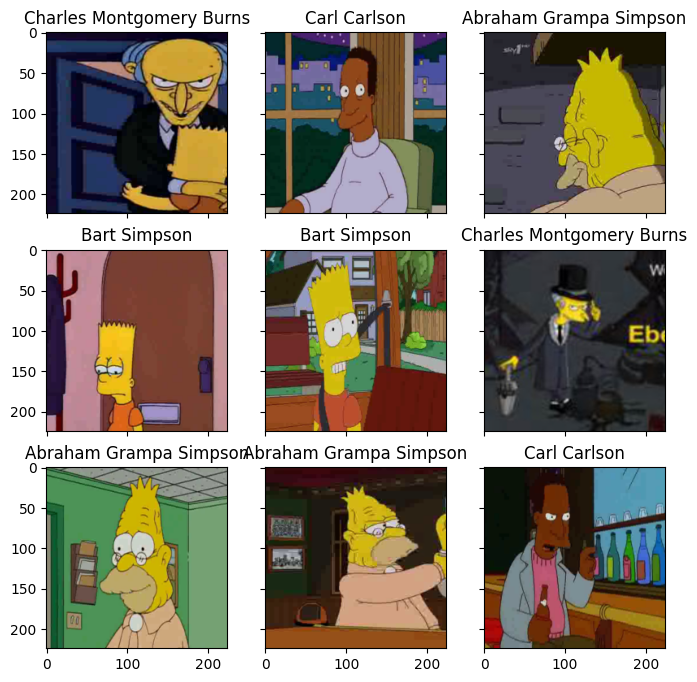

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

### Построение нейросети


#### Простая нейросеть


Воспользуемся нейронной сетью в ноутбуке, но немного изменим ее.

А также будем производить обучение на данных с аугментацией и балансировкой, которую я добавил в fit

*Описание слоев*:



1. размерность входа: 3x224x224 
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5

In [ ]:
# Очень простая сеть
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(96 * 5 * 5, 1024),
            nn.ReLU(),
            nn.Linear(1024, n_classes)
        )
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
    
    model.train(True)
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
            
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
            
            
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [ ]:
def train(train_files, val_files, model, epochs, batch_size, scheduler=None, opt=None, criterion=None):

    if opt is None:
            opt = torch.optim.Adam(model.parameters())
            
    if criterion is None:
        criterion = nn.CrossEntropyLoss()
        
    best_model_wts = model.state_dict()
    best_acc = 0.0
    
    # производим балансировку классов
    class_count = Counter(train_dataset.labels)
    
    class_weights = {i: 1 / (c**0.9 + 6) for i, c in class_count.items()}
    
    sample_weights = [0] * len(train_dataset)

    for i, label in enumerate(tqdm(train_dataset.labels)):
        class_weight = class_weights[label]
        sample_weights[i] = class_weight

    N = len(train_dataset)
    train_sampler = WeightedRandomSampler(sample_weights, num_samples=N, replacement=True)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
    
    
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        
        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            if val_acc > best_acc:  
                best_acc = val_acc
                best_model_wts = model.state_dict()

            if scheduler is not None:
                scheduler.step()
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            

    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
            
    return history

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=

Запустим обучение сети.

In [ ]:
optimizer = optim.Adam(simple_cnn.parameters(), lr=1e-3)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.5)

In [ ]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=20, batch_size=64, opt=optimizer, scheduler=exp_lr_scheduler)

  0%|          | 0/15699 [00:00<?, ?it/s]

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

loss 2.439997057283264

Epoch 001 train_loss: 2.4400     val_loss 1.7888 train_acc 0.3467 val_acc 0.5048
loss 1.0146706942137855

Epoch 002 train_loss: 1.0147     val_loss 1.3894 train_acc 0.7226 val_acc 0.6139
loss 0.5813789318337457

Epoch 003 train_loss: 0.5814     val_loss 1.1807 train_acc 0.8379 val_acc 0.6909
loss 0.40763640502936765

Epoch 004 train_loss: 0.4076     val_loss 1.0092 train_acc 0.8870 val_acc 0.7463
loss 0.31920268617395275

Epoch 005 train_loss: 0.3192     val_loss 1.0095 train_acc 0.9129 val_acc 0.7426
loss 0.25602444949704556

Epoch 006 train_loss: 0.2560     val_loss 0.9792 train_acc 0.9273 val_acc 0.7618
loss 0.2137137222661358

Epoch 007 train_loss: 0.2137     val_loss 1.0473 train_acc 0.9392 val_acc 0.7602
loss 0.14141536993521842

Epoch 008 train_loss: 0.1414     val_loss 0.8876 train_acc 0.9621 val_acc 0.8024
loss 0.09786707030227088

Epoch 009 train_loss: 0.0979     val_loss 0.9636 train_acc 0.9729 val_acc 0.7998
loss 0.08444075741282435

Epoch 010 train_

Построим кривые обучения

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

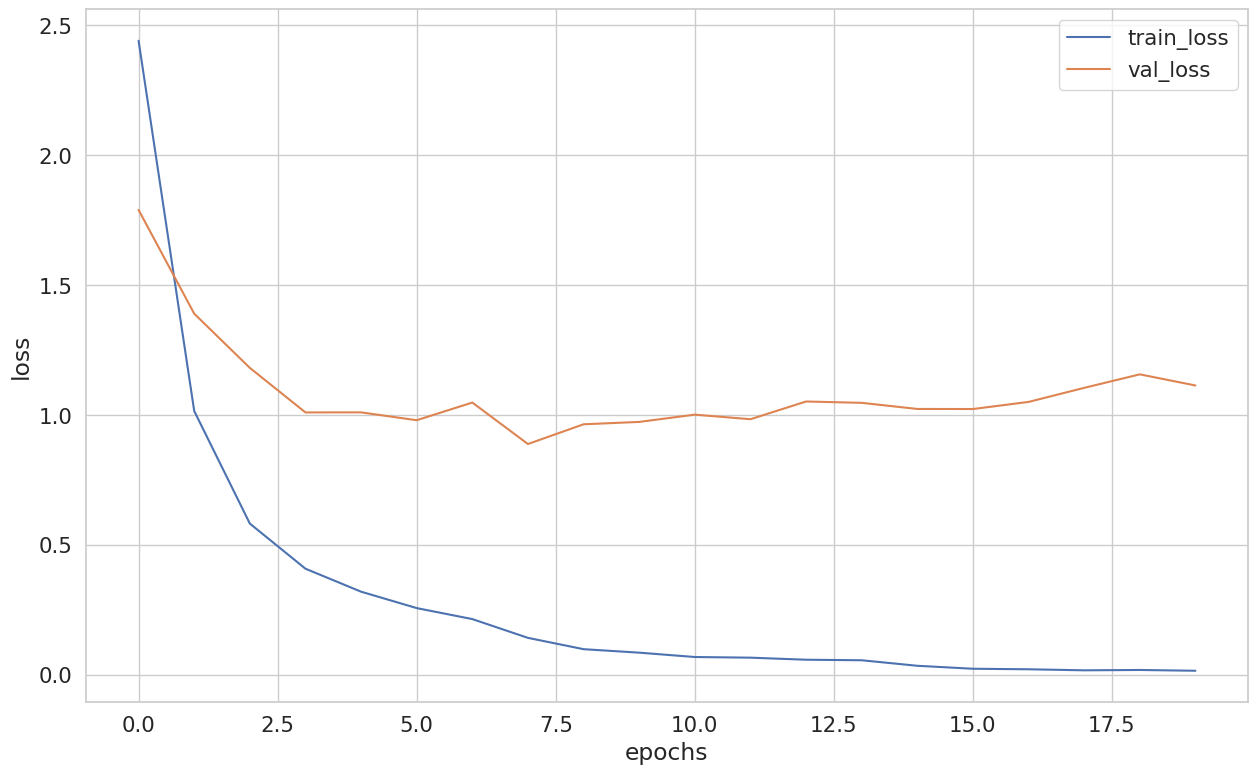

In [ ]:
sns.set(style="whitegrid", font_scale=1.4)

plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [ ]:
f1_score(actual_labels, y_pred, average='micro')

0.7

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

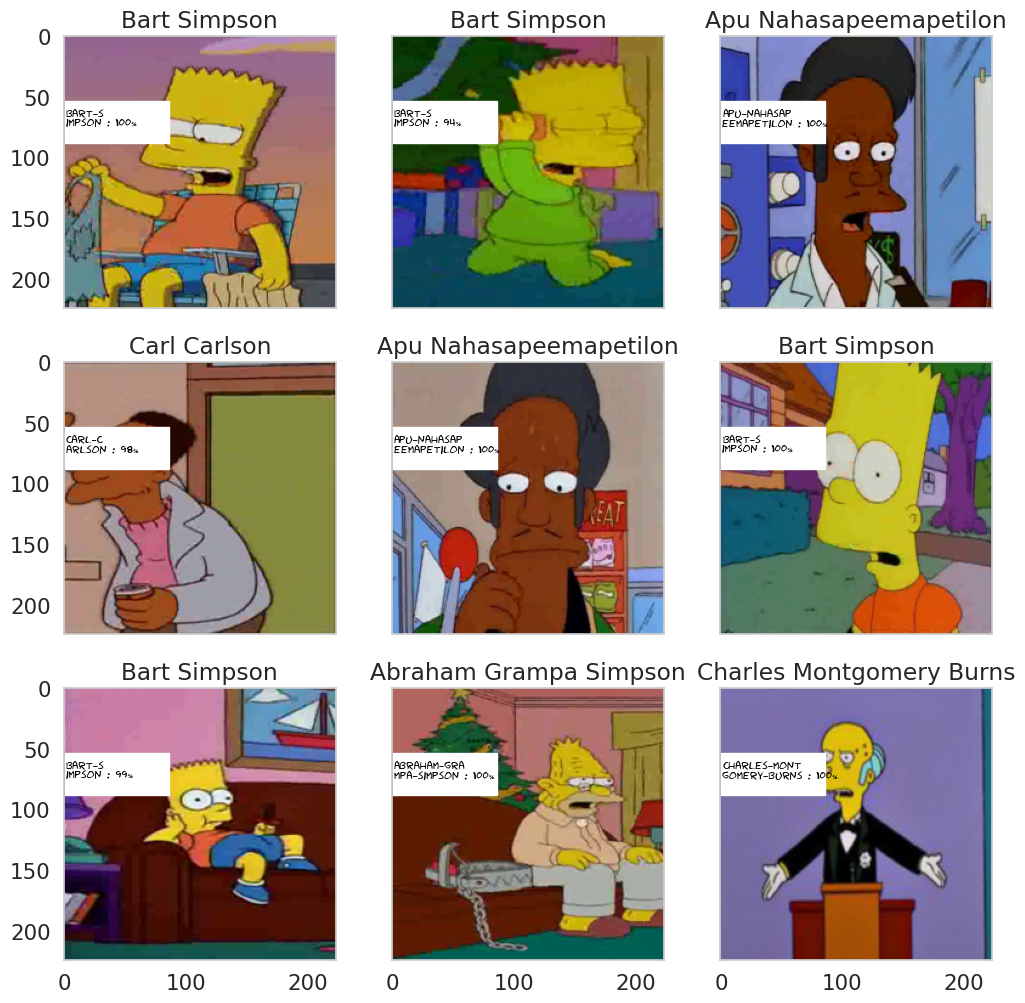

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

In [ ]:
# submission
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=128)
probs = predict(simple_cnn, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [ ]:
import pandas as pd
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()
my_submit.to_csv('./simple_cnn_baseline.csv', index=False)

Получилось на kaggle 0.95961
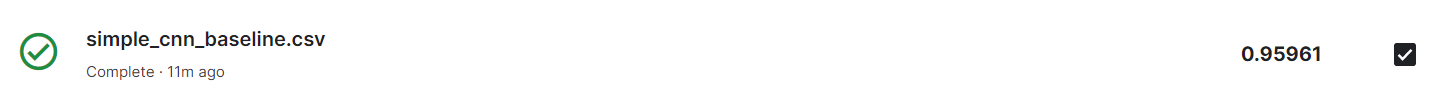

#### Зафайтюненная модель efficient net

In [ ]:
model_efic = models.efficientnet_b0(pretrained=True)
print(model_efic.classifier)

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
for param in model_efic.features[:-5].parameters():
    param.requires_grad = False
num_feature = model_efic.classifier[1].in_features
print(num_feature)
model_efic.classifier[1] = nn.Linear(num_feature, 42)
model_efic = model_efic.to(DEVICE)
print(model_efic.classifier)

1280
Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=42, bias=True)
)


In [ ]:
opt = torch.optim.Adam(model_efic.parameters(), lr=1e-4)
exp_lr_scheduler = lr_scheduler.StepLR(opt, step_size=7, gamma=0.1)

In [ ]:
history = train(train_dataset, val_dataset, model=model_efic, epochs=10, batch_size=64, opt=opt, scheduler=exp_lr_scheduler)

  0%|          | 0/15699 [00:00<?, ?it/s]

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 2.0731325188148735

Epoch 001 train_loss: 2.0731     val_loss 0.4389 train_acc 0.6081 val_acc 0.9205
loss 0.27106064483044034

Epoch 002 train_loss: 0.2711     val_loss 0.1917 train_acc 0.9552 val_acc 0.9551
loss 0.10986197818194281

Epoch 003 train_loss: 0.1099     val_loss 0.1525 train_acc 0.9796 val_acc 0.9616
loss 0.06408257189981724

Epoch 004 train_loss: 0.0641     val_loss 0.1397 train_acc 0.9871 val_acc 0.9662
loss 0.045796519197455726

Epoch 005 train_loss: 0.0458     val_loss 0.1333 train_acc 0.9903 val_acc 0.9669
loss 0.03649189715108818

Epoch 006 train_loss: 0.0365     val_loss 0.1267 train_acc 0.9922 val_acc 0.9681
loss 0.024823561581818056

Epoch 007 train_loss: 0.0248     val_loss 0.1228 train_acc 0.9953 val_acc 0.9704
loss 0.023119091024193173

Epoch 008 train_loss: 0.0231     val_loss 0.1242 train_acc 0.9950 val_acc 0.9710
loss 0.0210869232626529

Epoch 009 train_loss: 0.0211     val_loss 0.1234 train_acc 0.9959 val_acc 0.9708
loss 0.023643867553411847

Epoch 010

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

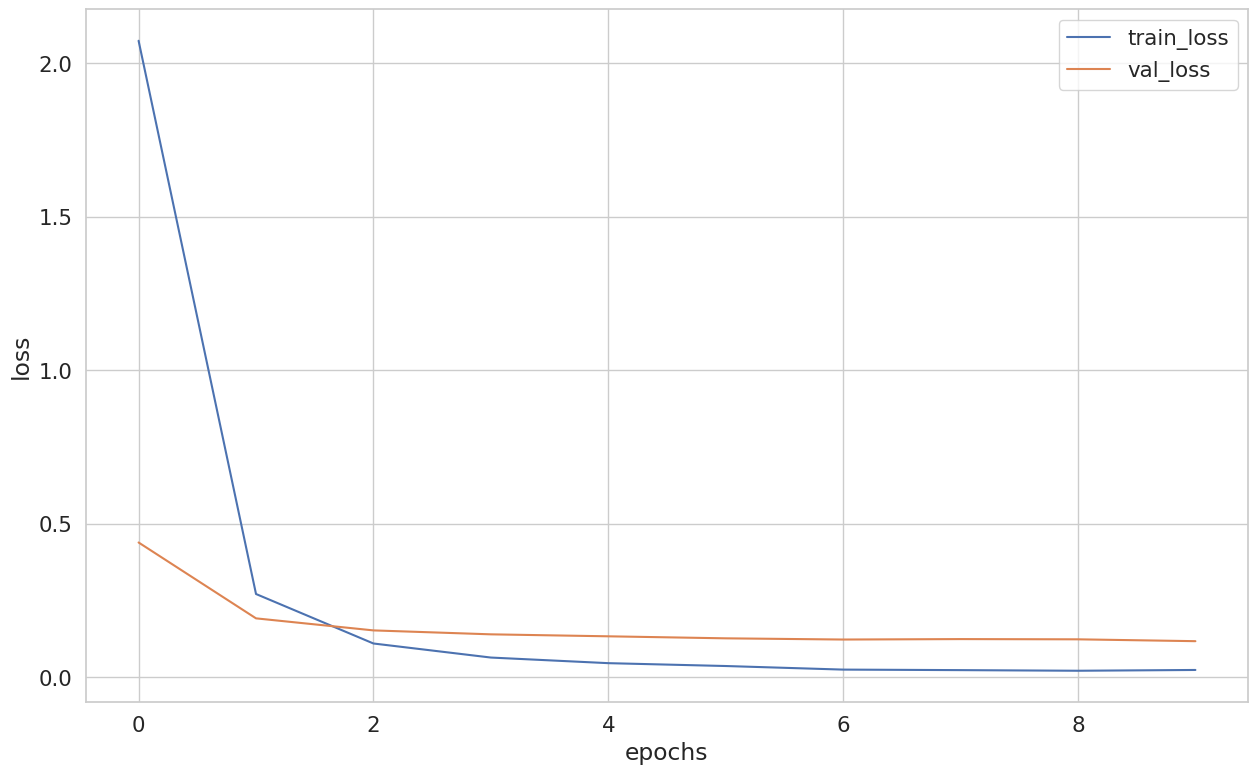

In [ ]:
sns.set(style="whitegrid", font_scale=1.4)

plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model_efic, imgs)

probs_ims = predict(model_efic, imgs)
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

f1_score(actual_labels, y_pred, average='micro')

0.9500000000000001

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=128)
probs = predict(model_efic, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [ ]:
import pandas as pd
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()
my_submit.to_csv('./efficient_baseline.csv', index=False)

Получилось на kaggle 0.99043
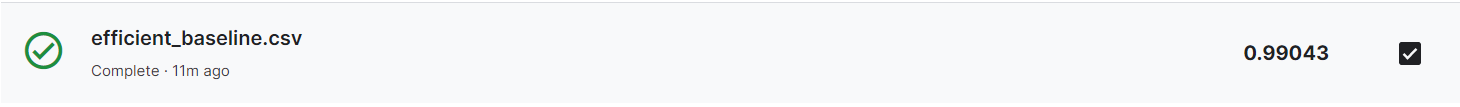

Этот результат и отправим

Продублирую информацию про kaggle:

**Мой kaggle: Vasiliy Kuzmin**

**Team name: Василий_Кузьмин_505358689**